## Importing modules

In [1]:
import numpy as np
import pydicom
import glob
import matplotlib.pyplot as plt
import cv2
from read_roi import read_roi_file
from ipywidgets import interact, fixed, IntSlider, IntRangeSlider

## Getting dcm files

In [2]:
dir_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2AX'

## Reading slice

In [3]:
def rescale(im, max, min):
    return ((im.astype(float) - min) * (1. / (max - min)) * 255.).astype('uint8')


def read_slices(filename):
    name, ext = filename.split('.')

    if ext != 'dcm':
        raise ValueError('Input filename must be a DICOM file')

    slide = pydicom.dcmread(filename).pixel_array

    return slide

def get_slice(dir_path):

    files = glob.glob(dir_path + '/*.dcm')
    # ordering as istance number
    z = [float(pydicom.read_file(f, force=True).get(
        "InstanceNumber", "0") - 1) for f in files]
    order = np.argsort(z)
    files = np.asarray(files)[order]

    slice = [read_slices(f) for f in files]

    Max = max([x.max() for x in slice])
    Min = min([x.min() for x in slice])

    slice = [rescale(x, Max, Min) for x in slice]

    slice = np.asarray(slice)

    return slice

slice = get_slice(dir_path=dir_path)    


### Slice info

In [4]:

def get_slice_info(slice):

    depth, height, width = slice.shape
    print(
        f"The image object has the following dimensions: depth:{depth}, height: {height}, width:{width}")

get_slice_info(slice)        

The image object has the following dimensions: depth:30, height: 512, width:512


# 2D Exploration

## Plotting Slice

### Random layer plot

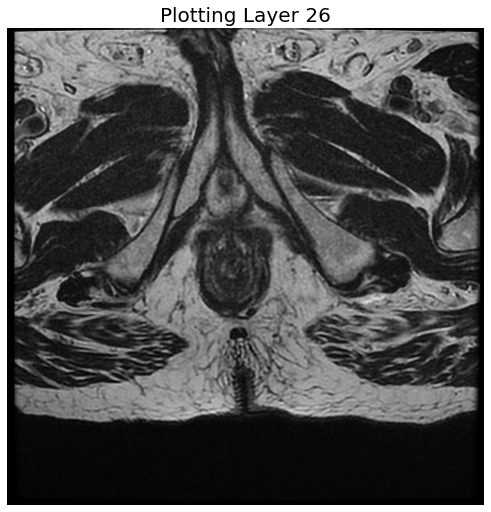

In [5]:
def plot_random_layer(slice):

    maxval = slice.shape[0]
    # Select random layer number
    i = np.random.randint(0, maxval)

    plt.figure(figsize=(12, 7), constrained_layout=True)
    plt.imshow(slice[i, :, :], cmap='gray')
    plt.title(f"Plotting Layer {i}", fontsize=20)
    plt.axis('off')

plot_random_layer(slice)    

### Interactive slice plot

In [6]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_slice(layer):
    plt.figure(figsize=(12, 7), constrained_layout=True)
    plt.imshow(slice[layer, :, :], cmap='gray')
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

## ROIS

### Getting ROIs

In [7]:
roi_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2ROI'

def _dict(dict_list):
    '''

    useful to get true_dict since roi is {name file : true_dict}.

    '''

    true_dict = []

    for i in dict_list:
        _dict = list(i.values())

        for j in _dict:
            keys = j.keys()
            vals = j.values()

            _dict = {key: val for key, val in zip(keys, vals)}
            true_dict.append(_dict)

    return true_dict

def get_rois(roi_path): 

    rois_list = glob.glob(roi_path + '/*.roi')   

    rois = [read_roi_file(roi) for roi in rois_list]
    rois = _dict(rois)

    # ordering dictionaries by positions and removing rois without x y coords
    rois = sorted(rois, key=lambda d: list(d.values())[-1])
    rois = list(filter(lambda d: d['type'] != 'composite', rois))

    positions = []
    xs = []
    ys = []
    for i in range(len(rois)):
        position = rois[i]['position']
        x = rois[i]['x']
        y = rois[i]['y']

        x.append(x[0])
        y.append(y[0])

        positions.append(position)
        xs.append(x)
        ys.append(y)

    return positions, xs, ys

positions, xs, ys = get_rois(roi_path=roi_path)        

### Interactive ROIs plot

In [8]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_roi(layer):
    plt.figure(figsize=(12, 7))
    plt.imshow(slice[layer, :, :], cmap='gray')
    if layer in positions:
        plt.plot(xs[layer - positions[0]], ys[layer - positions[0]], color="red",
                 linestyle='dashed', linewidth=1)
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Example of ROI

7

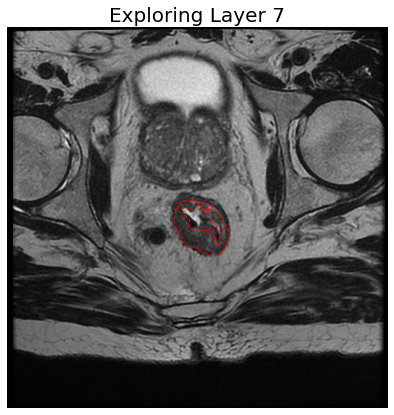

In [9]:
from random import choice 

layer = choice(positions)
explore_roi(layer=layer)

### Interactive ROIs masks

In [10]:

@interact(layer=(positions[0], positions[-1]))
def explore_mask(layer):



    image = slice[layer, :, :].copy()

    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(" ROI Mask")
    ax[1].axis('off')

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].plot(xs[layer - positions[0]],ys[layer - positions[0]] , color="red",
                linestyle='dashed', linewidth=1)
    ax[0].set_title("ROI")
    ax[0].axis('off')

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)


interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of ROI mask

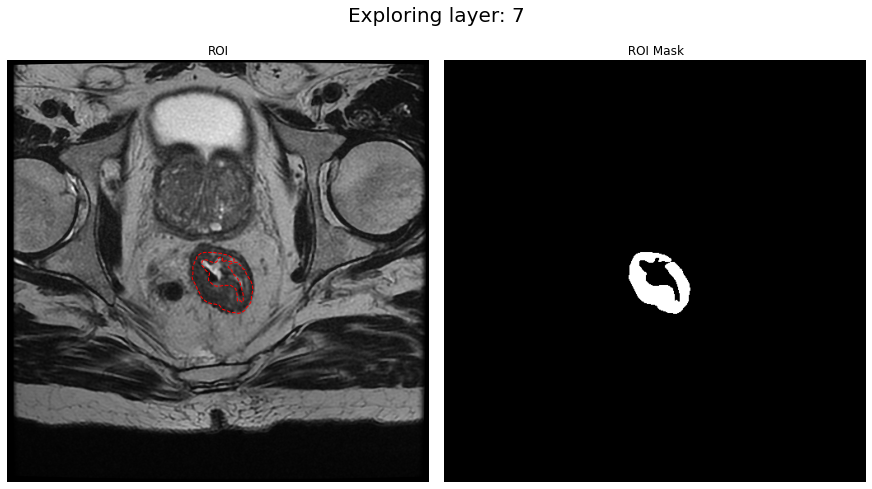

In [11]:
explore_mask(layer=layer)

### Appling ROIs Mask

In [12]:

@interact(slice = fixed(slice), layer=(positions[0], positions[-1]))
def explore_masked_image(slice,layer):
    
    image = slice[layer, :, :].copy()

    
    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    masked_img = cv2.bitwise_and(slice[layer, :, :].copy(), image, mask = mask)

    fig, ax = plt.subplots(1, 3, figsize=(12, 7), constrained_layout=True)

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis('off')

    
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("ROI Mask")
    ax[1].axis('off')

    ax[2].imshow(masked_img, cmap="gray")
    ax[2].set_title("Applied ROI mask")
    ax[2].axis('off')
    fig.suptitle(f'Exploring layer {layer}', fontsize=20)
        

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of applied mask

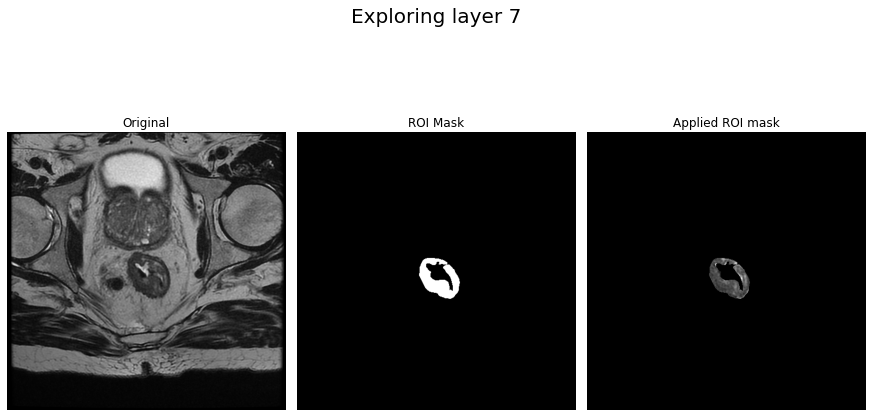

In [13]:
explore_masked_image(slice= slice, layer=layer)

# Traditional image processing segmentation

### Exploring histogram

In [14]:
@interact(slice=fixed(slice), layer=(0, slice.shape[0] - 1))
def explore_histogram(slice, layer):

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True) 

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256, [0,256], color="black")
    ax[1].set_title("Histogram")

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example 

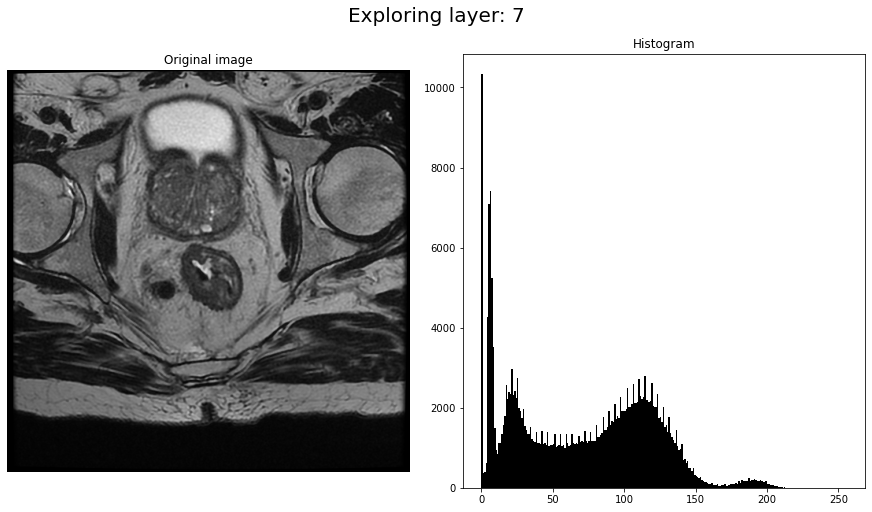

In [15]:
explore_histogram(slice=slice, layer=layer)

### Histogram Global Thresholding

In [16]:
@interact(slice=fixed(slice),layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,255], min=0, max=255, step=1, ) )
def manual_tresh(slice, layer, threshold):

    image = slice[layer, : ,:].copy()


    t_min = threshold[0]
    t_max = threshold[1]
    

    mask = cv2.threshold(image, t_min, t_max, cv2.THRESH_BINARY_INV)[1]




    fig, ax=plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True) 


    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256,[0,256], color="black")
    ax[1].set_title("Histogram")
    ax[1].vlines(t_min,0, 10000, color="red", linestyle="dashed")
    ax[1].vlines(t_max,0, 10000, color="red", linestyle="dashed")
    ax[1].text(t_min, 10000, "$T_{min}$")
    ax[1].text(t_max, 10000, "$T_{max}$")
    ax[1].set_yticks([])
    


    ax[2].imshow(mask, cmap="gray")
    ax[2].set_title("Thresholded Image")
    ax[2].axis("off")



    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)

    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 255), descri…

### Non interactive example

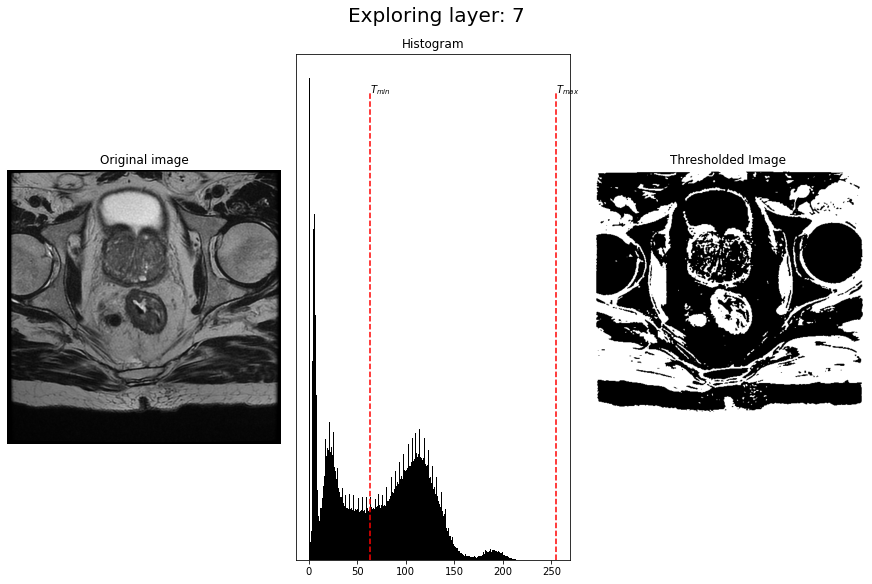

In [17]:
manual_tresh(slice=slice, layer=layer, threshold=(63, 255))

### Adaptive Threshold methods

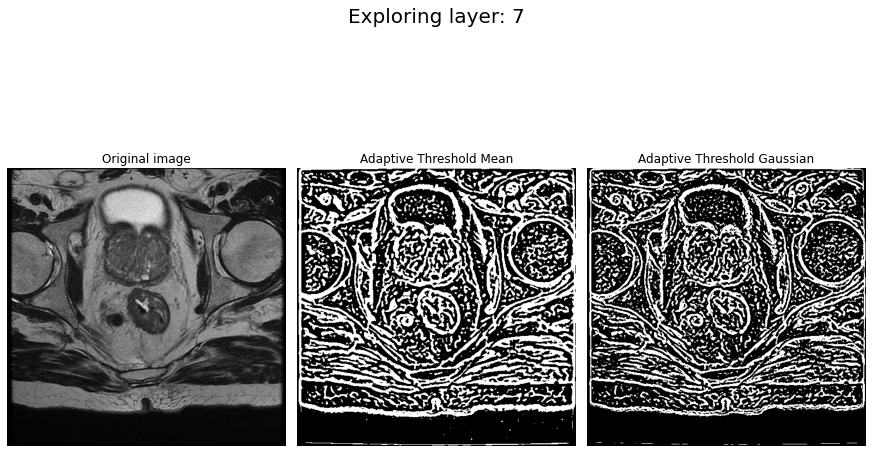

In [18]:

def adaptive_threshold(slice, layer):
    img = image = slice[layer, : ,:].copy()
    blur = cv2.medianBlur(img,ksize=5)

    th = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
    th2 = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

    fig, ax = plt.subplots(1, 3, figsize=(12,8), constrained_layout=True)

    ax[0].imshow(img, "gray")
    ax[0].axis("off")
    ax[0].set_title("Original image")

    ax[1].imshow(th, "gray")
    ax[1].axis("off")
    ax[1].set_title("Adaptive Threshold Mean")

    ax[2].imshow(th2, "gray")
    ax[2].axis("off")
    ax[2].set_title("Adaptive Threshold Gaussian")

    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)

adaptive_threshold(slice=slice, layer=layer)

### Otsu

In [19]:
    
 @interact(slice=fixed(slice), layer=(0, slice.shape[0] - 1))   
def otsu_thresholding(slice, layer):   

    img = slice[layer, : ,:].copy()
    gauss = cv2.GaussianBlur(img, (5, 5), 0)

    t_min = 0
    t_max = 255

    thresh_otsu = cv2.threshold(gauss,t_min, t_max,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(slice[layer, : ,:], cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(thresh_otsu, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Otsu")

    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example

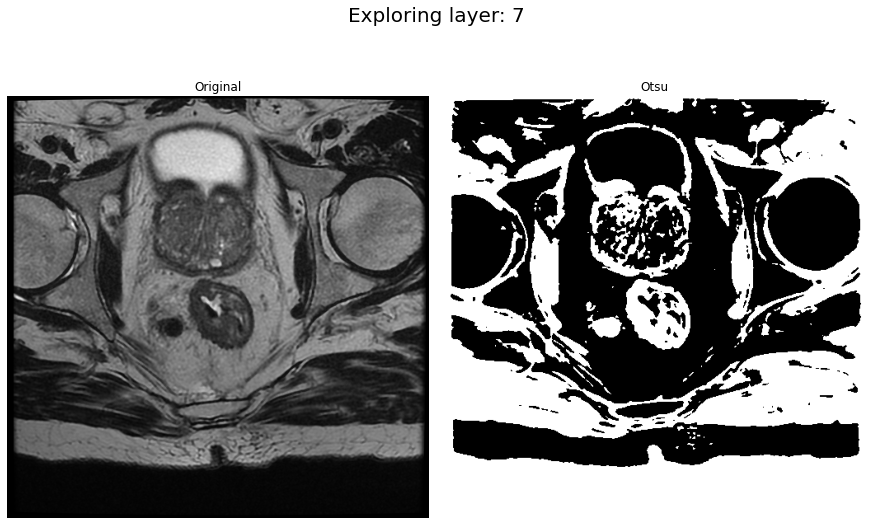

In [20]:
 otsu_thresholding(slice= slice, layer=layer)

### Boxed Masks

In [21]:

@interact(slice=fixed(slice), layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def box_fov(slice, layer, threshold):


    img = slice[layer, : ,:].copy()
    box = np.zeros(img.shape[:2], np.uint8)
    box[150:350, 150:350] = 255

    boxed_original = cv2.bitwise_and(img,img,mask = box)

    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(img, t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 256,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)

   
    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(boxed_original, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    


interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 120), descri…

### Non interactive example

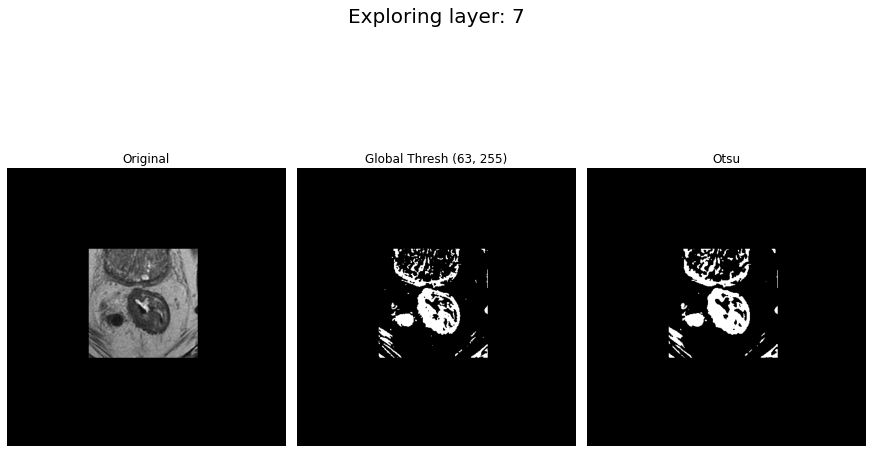

In [22]:
box_fov(slice=slice, layer=layer, threshold=(63, 255))

### Comparing masks

In [23]:
@interact(slice=fixed(slice), layer=(positions[0], positions[-1]), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def comparing_masks(slice, layer, threshold):

    image = slice[layer, : ,:].copy()
    box = np.zeros(image.shape[:2], np.uint8)
    box[150:350, 150:350] = 255


    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    true_mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]


    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(slice[layer, : ,:].copy(), t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(slice[layer, : ,:].copy(), (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)


    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(true_mask, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Ground truth")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title("Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), IntRangeSlider(value=(63, 120),…

### Non interactive Example

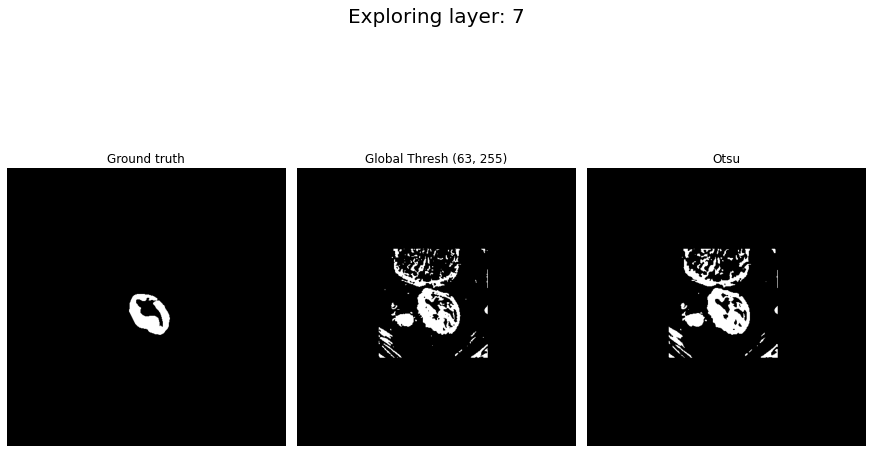

In [24]:
comparing_masks(slice=slice, layer=layer, threshold=(63, 255))

### Gabor filters

In [26]:
kmax=50
sigma_max = 10
theta_max = 1*np.pi
lamb_max = 2*np.pi
gamma_max = 1
phi_max = 1


@interact(slice=fixed(slice), layer = (0, slice.shape[0] - 1) , ksize=(3, kmax), sigma=(0, sigma_max), theta=(0, theta_max), lamb=(0, lamb_max), gamma=(0, gamma_max), phi=(0, phi_max) )
def gabor_filter(slice, layer, ksize, sigma, theta, lamb, gamma, phi):

    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

    
    img = slice[layer, :, :].copy()

    filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

    fig, ax = plt.subplots(1, 2, figsize=(12, 8 ), constrained_layout=True)

    ax[0].imshow(kernel)
    ax[0].set_title("Gabor Kernel")

    ax[1].imshow(filtered_img, cmap="gray")
    ax[1].set_title("Filtered image")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
 

interactive(children=(IntSlider(value=14, description='layer', max=29), IntSlider(value=26, description='ksize…

### Non interactive Example

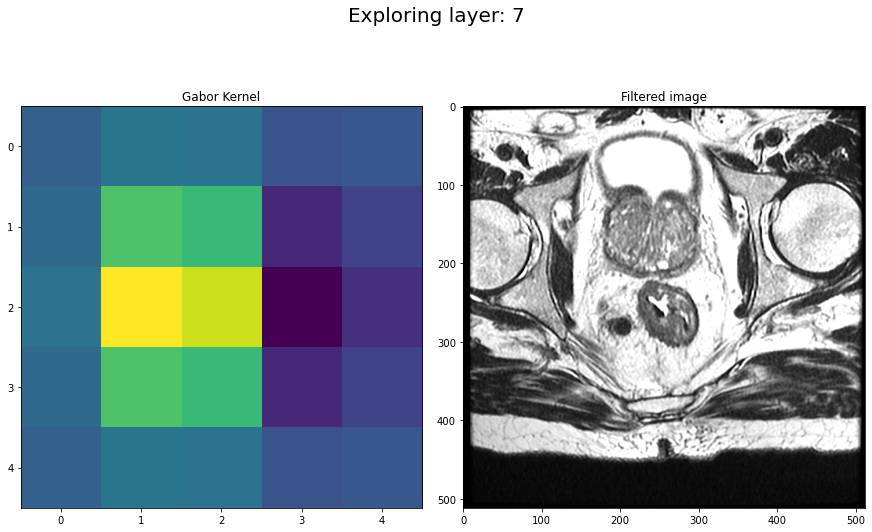

In [27]:

ksize=5
sigma = 1
theta = 1*np.pi
lamb = 2*np.pi
gamma = 1
phi  = 1



gabor_filter(slice=slice, layer=layer, ksize=ksize, sigma=sigma, theta=theta, lamb=lamb, gamma=gamma, phi=phi)

### Denoising with Non Local Means filter

In [28]:
from skimage.restoration import denoise_nl_means, estimate_sigma

alpha=5

@interact(slice=fixed(slice), layer=(0, slice.shape[0] - 1), alpha=fixed(alpha))
def denoise_nlm(slice, layer, alpha, show=True):
    
    img = slice[layer, :, :].copy()

    sigma = np.mean(estimate_sigma(img, multichannel=False))

    
    denoise_img = denoise_nl_means(img, h=alpha*sigma, patch_size=5, patch_distance=3, multichannel=False, preserve_range=True)


    if show:
        fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("original")

        ax[1].imshow(denoise_img, cmap="gray")
        ax[1].set_title("after NLM denoise")

        fig.suptitle(f"Exploring layer {layer}", fontsize=20)

    else:
        return denoise_img
    

interactive(children=(IntSlider(value=14, description='layer', max=29), Checkbox(value=True, description='show…

### Non interactive example

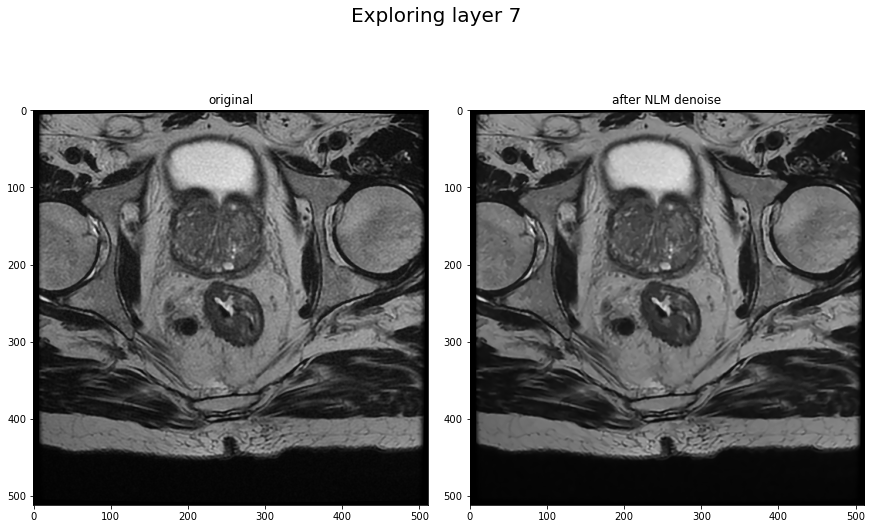

In [29]:
denoise_nlm(slice=slice, layer=layer, alpha=alpha, show=True)

In [30]:

@interact(slice=fixed(slice), layer=(0, slice.shape[0] - 1), alpha=fixed(alpha))
def compare_denoised_histo(slice, layer, alpha):

    img = slice[layer, :, :].copy()

    denoised_img = denoise_nlm(slice, layer, alpha=alpha, show=False)



    fig, ax=plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True) 

    ax[0][0].imshow(denoised_img, cmap="gray")
    ax[0][0].set_title("denoised")
    ax[0][0].axis("off")


    ax[0][1].hist(denoised_img.ravel(),256, [0,256], color="black")
    ax[0][1].set_title("Histogram")

    ax[1][0].imshow(img, cmap="gray")
    ax[1][0].set_title("original")
    ax[1][0].axis("off")

    ax[1][1].hist(img.ravel(),256, [0,256], color="black")
    ax[1][1].set_title("Histogram")

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
    plt.show()



interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example

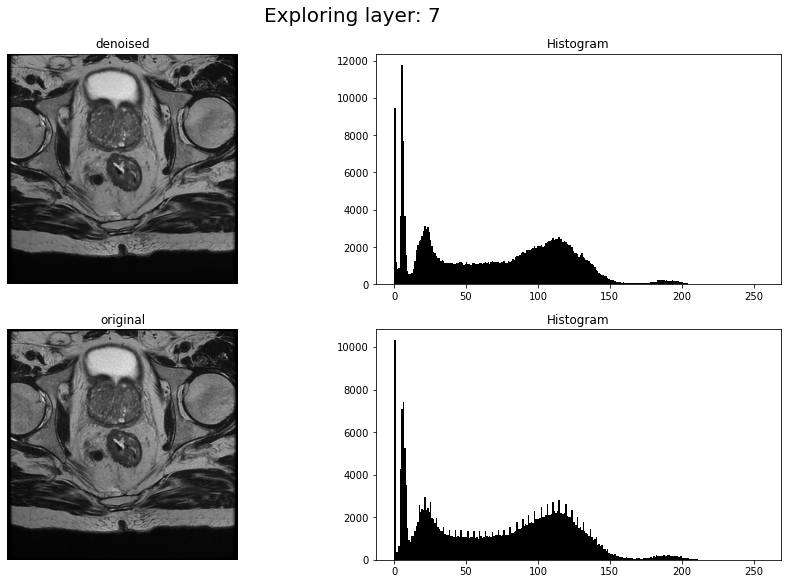

In [31]:
compare_denoised_histo(slice=slice, layer=layer, alpha=alpha)

## Zoom image

In [107]:
from scipy.ndimage import zoom

def zoom_image(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out


In [112]:
zoom_factor=1.5

@interact(slice=fixed(slice), layer=(positions[0], positions[-1]), zoom_factor=fixed(zoom_factor), show_mask=True)
def compare_zoomed(slice, layer, zoom_factor, show_mask):

    img = slice[layer, : ,:].copy()
    zoomed_img = zoom_image(img=img, zoom_factor=zoom_factor)

    if show_mask:
        mask_label = make_labels(slice=slice, layer=layer)
        zoomed_mask = zoom_image(img=mask_label, zoom_factor=zoom_factor)

        fig, ax = plt.subplots(2, 2, figsize=(12,8), constrained_layout=True)
        ax[0][0].imshow(img, cmap="gray")
        ax[0][0].set_title("original")

        ax[0][1].imshow(zoomed_img, cmap="gray")
        ax[0][1].set_title(f"zoom x {zoom_factor}")

        ax[1][0].imshow(mask_label, cmap="gray")
        ax[1][0].set_title("original mask")

        ax[1][1].imshow(zoomed_mask, cmap="gray")
        ax[1][1].set_title(f"zoom x {zoom_factor}")

        fig.suptitle(f"Exploring layer: {layer}", fontsize=20)
    else:

        fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title("original")

        ax[1].imshow(zoomed_img, cmap="gray")
        ax[1].set_title(f"zoom x {zoom_factor}")
        fig.suptitle(f"Exploring layer: {layer}", fontsize=20)

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Checkbox(value=True, descriptio…

### Example of Zoomed image

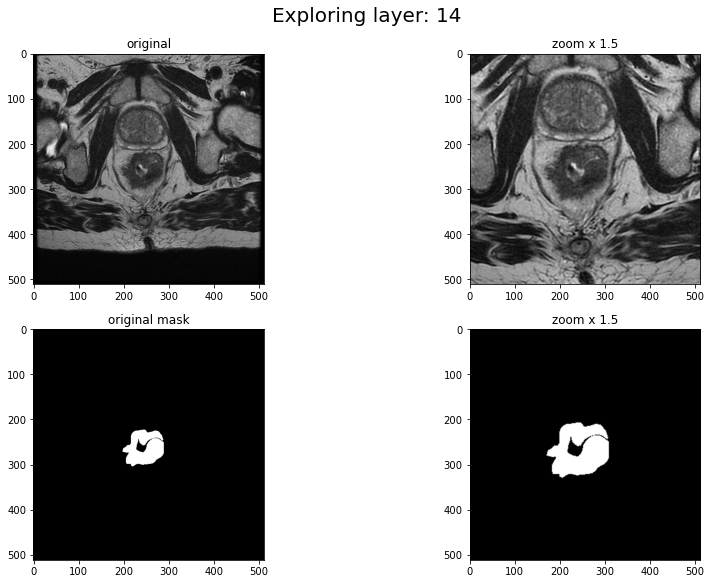

In [113]:
compare_zoomed(slice=slice, layer=14, zoom_factor=zoom_factor, show_mask=True)

# Machine Learning Approach

## Importing modules for ML 

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


## Feature extraction

### Labels

In [33]:
def make_labels(slice, layer):

    if not layer in positions:
        print("no labels found!")
        

    else:
        #create layers from given ROI points
        image = slice[layer, :, :].copy()

        
        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        label = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

        return label

In [51]:
def features_extraction(slice, layer, ksize, Train_mode=False):

    df = pd.DataFrame() # create dataframe for features


    img = slice[layer, :, :].copy()

    img_vect = img.reshape(-1) # reshape 2D image into 1D vector
    df['Original pixels'] = img_vect 


    #generate a bunch of Gabor filters  
    i = 1 
    for theta in np.arange(0, 3 * np.pi, np.pi/4):
        for sigma in np.arange(0, 5, 1):
            for lamb in np.arange(0, 3 * np.pi, np.pi/4):
                for gamma in np.arange(0,1, 0.5):
                    for phi in np.arange(0,1, 0.5):
                        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        
                        fimg_vect = fimg.reshape(-1)

                        Gabor_label = "Gabor" + str(i)
                        df[Gabor_label] = fimg_vect

                        i += 1



                        
    if Train_mode:

        labels = make_labels(slice=slice, layer=layer)
        labels_vect = labels.reshape(-1)
        df['labels'] = labels_vect

    return df


df = features_extraction(slice=slice, layer=14, ksize=5, Train_mode=True)



## Defining Variables

In [52]:
Y = df['labels'].values
X = df.drop(labels= ['labels'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=20)

## Random Forest Classifier

In [53]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)

### Metrics

In [54]:

def print_metrics(Y_test, prediction_test):
    print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))

    print("Balanced accuracy = ", metrics.balanced_accuracy_score(Y_test, prediction_test)) #! deal with imbalanced datasets.


    print("f1_score (macro) = ", metrics.f1_score(Y_test, prediction_test, average='macro')) # macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. 

    print("f1_score (micro) = ", metrics.f1_score(Y_test, prediction_test, average='micro')) # Calculate metrics globally by counting the total true positives, false negatives and false positives
    metrics.homogeneity_score
    print("homogeneity_score = ", metrics.homogeneity_score(Y_test, prediction_test))

print_metrics(Y_test=Y_test, prediction_test=prediction_test)    

Accuracy =  0.9837167987269894
Balanced accuracy =  0.621483829817825
f1_score (macro) =  0.682010161867775
f1_score (micro) =  0.9837167987269894
homogeneity_score =  0.16842138954219074


### confusion matrix

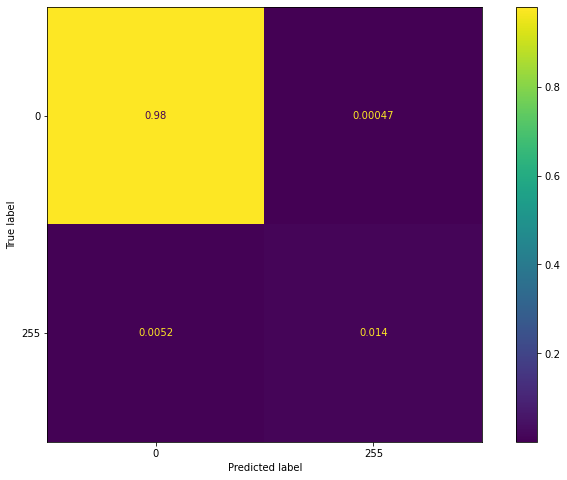

In [55]:
conf_matrix = metrics.confusion_matrix(Y_test, prediction_test, normalize='all')

fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, X, Y, normalize='all', ax=ax)
plt.show() 

### Most relevant filters

In [56]:

features_list = list(X.columns)
features_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

pd.options.display.float_format = '{:,.10f}'.format
print(features_imp)


t = 0.0005
print('\n', f'Greater than {t}', '\n\n', features_imp[features_imp > t])

Gabor1648   0.0054784238
Gabor686    0.0051411368
Gabor638    0.0047656699
Gabor2558   0.0043920839
Gabor1118   0.0041837835
                ...     
Gabor1299   0.0000000000
Gabor1298   0.0000000000
Gabor1297   0.0000000000
Gabor1252   0.0000000000
Gabor2880   0.0000000000
Length: 2881, dtype: float64

 Greater than 0.0005 

 Gabor1648   0.0054784238
Gabor686    0.0051411368
Gabor638    0.0047656699
Gabor2558   0.0043920839
Gabor1118   0.0041837835
                ...     
Gabor1048   0.0005122949
Gabor80     0.0005120835
Gabor1034   0.0005089552
Gabor2763   0.0005065170
Gabor2474   0.0005013266
Length: 818, dtype: float64


## Pickling model

In [57]:
import pickle

filename = 'RF_model'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

## Test model predictions 

### Loading model

In [58]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

### Test on trained image

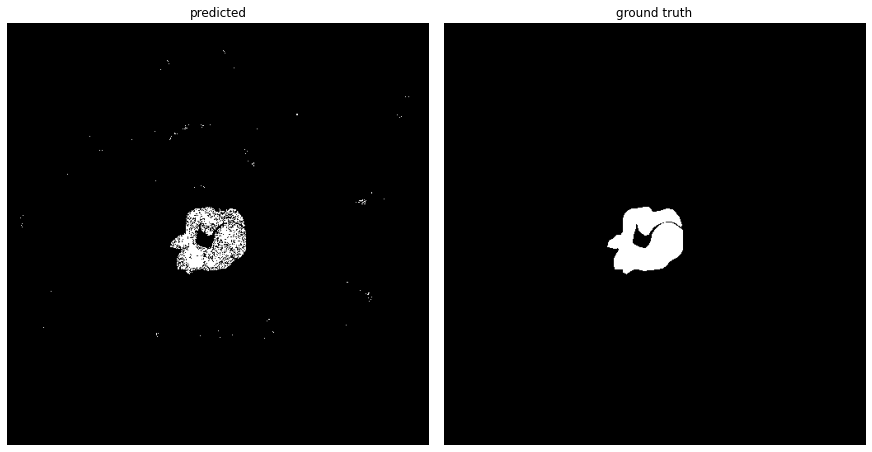

In [59]:
result = load_model.predict(X)

predicted = result.reshape(slice.shape[1:3])

ground_truth = make_labels(slice=slice, layer=14)

def show_model_result(ground_truth, predicted):

    fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

    ax[0].imshow(predicted, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("predicted")


    ax[1].imshow(ground_truth, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title("ground truth")

show_model_result(ground_truth=ground_truth, predicted=predicted)

### Test on different image

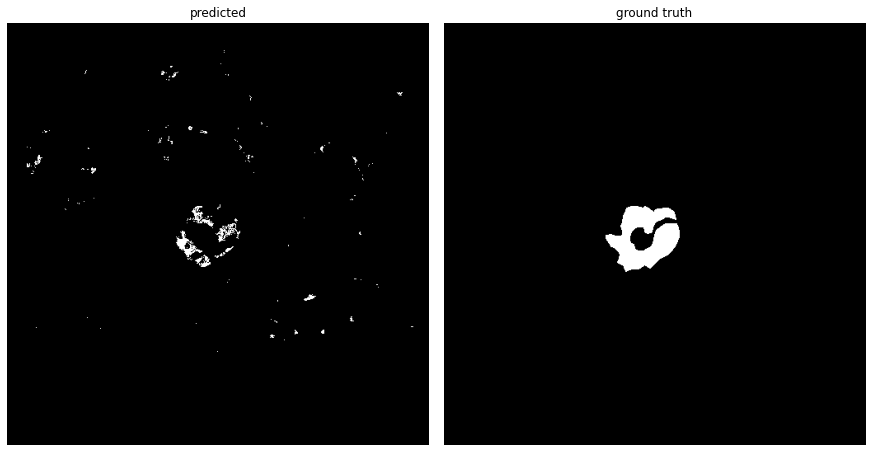

In [60]:
layer = 15

X_2 = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)


result = load_model.predict(X_2)

predicted = result.reshape(slice.shape[1:3])

ground_truth = make_labels(slice=slice, layer=layer)

show_model_result(ground_truth= ground_truth, predicted=predicted)


## Multi-image Training

### Features extraction

In [61]:

df_ = features_extraction(slice=slice, layer=14, ksize=5, Train_mode=True)
df_1 = features_extraction(slice=slice, layer=15, ksize=5, Train_mode=True)


multi_df = pd.concat([ df_, df_1])



### Defining Variables

In [62]:
YY = multi_df['labels'].values
XX = multi_df.drop(labels= ['labels'], axis=1)

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.25, random_state=20)

### ML Model

In [63]:
model = RandomForestClassifier(n_estimators=80, random_state=42)

model.fit(XX_train, YY_train)

prediction_test = model.predict(XX_test)
print("Accuracy = ", metrics.accuracy_score(YY_test, prediction_test))

Accuracy =  0.9852676391601562


### Most relevant features

In [64]:
features_list = list(XX.columns)
features_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

pd.options.display.float_format = '{:,.10f}'.format
print(features_imp)

t = 0.0005
print('\n', f'Greater than {t}', '\n\n', features_imp[features_imp > t])

Gabor688    0.0054730190
Gabor1648   0.0048787460
Gabor2558   0.0047081642
Gabor1070   0.0044953839
Gabor640    0.0042942954
                ...     
Gabor1298   0.0000000000
Gabor1297   0.0000000000
Gabor1293   0.0000000000
Gabor1289   0.0000000000
Gabor2880   0.0000000000
Length: 2881, dtype: float64

 Greater than 0.0005 

 Gabor688    0.0054730190
Gabor1648   0.0048787460
Gabor2558   0.0047081642
Gabor1070   0.0044953839
Gabor640    0.0042942954
                ...     
Gabor2045   0.0005110309
Gabor1657   0.0005080462
Gabor2478   0.0005076436
Gabor558    0.0005016856
Gabor779    0.0005004053
Length: 828, dtype: float64


### Metrics

In [66]:
print_metrics(Y_test=YY_test, prediction_test=prediction_test)

Accuracy =  0.9852676391601562
Balanced accuracy =  0.6140732704077685
f1_score (macro) =  0.6730404450507275
f1_score (micro) =  0.9852676391601562
homogeneity_score =  0.1581444068631885


### Confusion Matrix

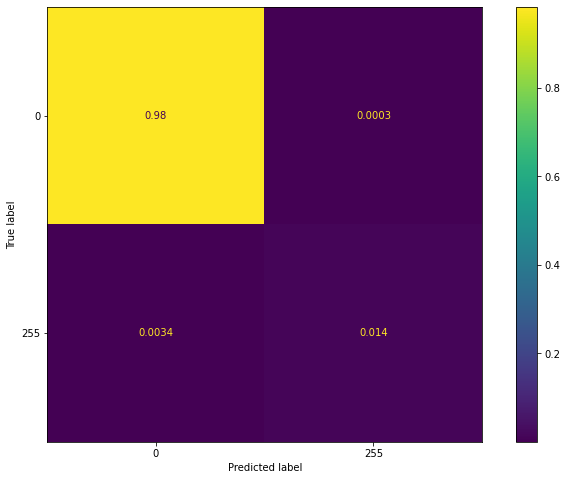

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, XX, YY, normalize='all', ax=ax)
plt.show() 

### saving model

In [67]:
filename = 'RF_model_multi'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

### loading model

In [68]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

### Test on trained image

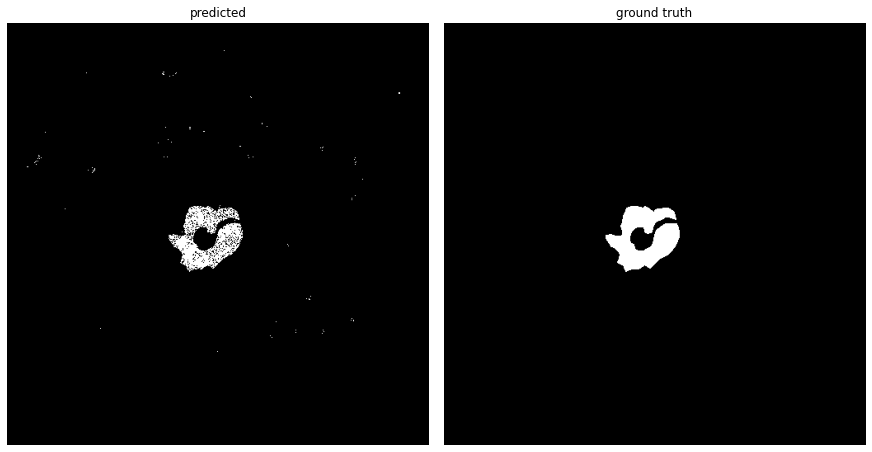

In [70]:
layer = 15

X = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_labels(slice=slice, layer=layer)

show_model_result(ground_truth=ground_truth,predicted=predicted)

### Test on different image

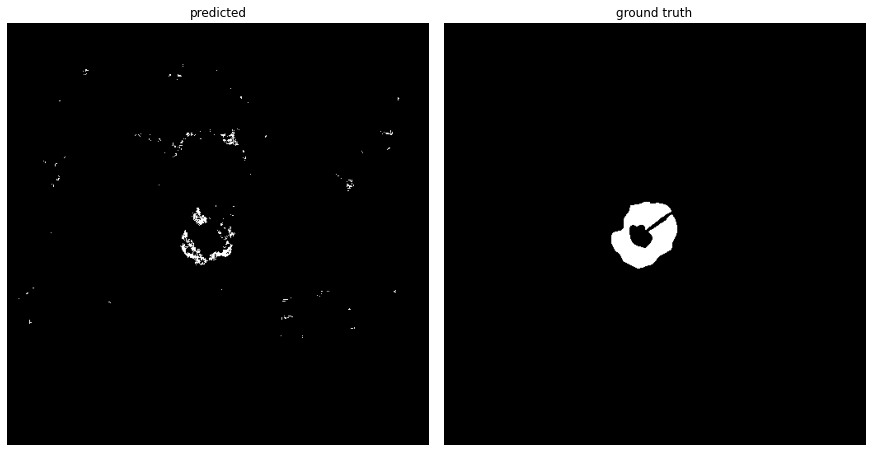

In [71]:
layer = 16

X = features_extraction(slice=slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_labels(slice=slice, layer=layer)

show_model_result(ground_truth=ground_truth,predicted=predicted)

## Training on denoised images

### pre-processing

In [72]:
def denoise_slice(slice, alpha, patch_size, patch_distance):

    denoised_slice = np.zeros_like(slice)

    for layer in range(slice.shape[0]):

        img = slice[layer, :, :].copy()

        sigma = np.mean(estimate_sigma(img, multichannel=False))

        
        denoised_img = denoise_nl_means(img, h=alpha*sigma, patch_size=patch_size, patch_distance=patch_distance, multichannel=False, preserve_range=True)

        denoised_slice[layer, : ,:] = denoised_img
        
    return denoised_slice


In [75]:
denoised_slice = denoise_slice(slice=slice, alpha=5, patch_size=5, patch_distance=3)

In [76]:
denoised_slice.shape

(30, 512, 512)

### features extraction

In [77]:
df = features_extraction(slice=denoised_slice, layer=14, ksize=5, Train_mode=True)

### Defining variables

In [78]:
Y = df['labels'].values
X = df.drop(labels= ['labels'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35, random_state=20)

### RandomForestClassifier

In [79]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)


Accuracy =  0.9855805386317316


### Metrics

In [80]:
print_metrics(Y_test=Y_test, prediction_test=prediction_test)

Accuracy =  0.9855805386317316
Balanced accuracy =  0.6632387020257394
f1_score (macro) =  0.732904261918091
f1_score (micro) =  0.9855805386317316
homogeneity_score =  0.24094544417447794


### Confusion matrix

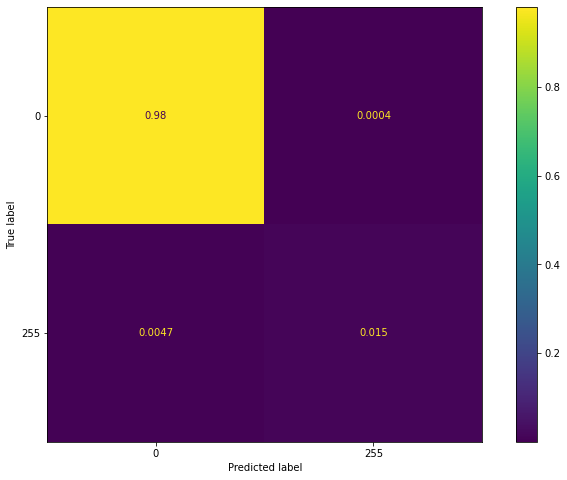

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
metrics.plot_confusion_matrix(model, X, Y, normalize='all', ax=ax)
plt.show() 

### Saving model

In [82]:
filename = 'RF_model_denoised'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

### Loading model

In [83]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

## Test on trained image

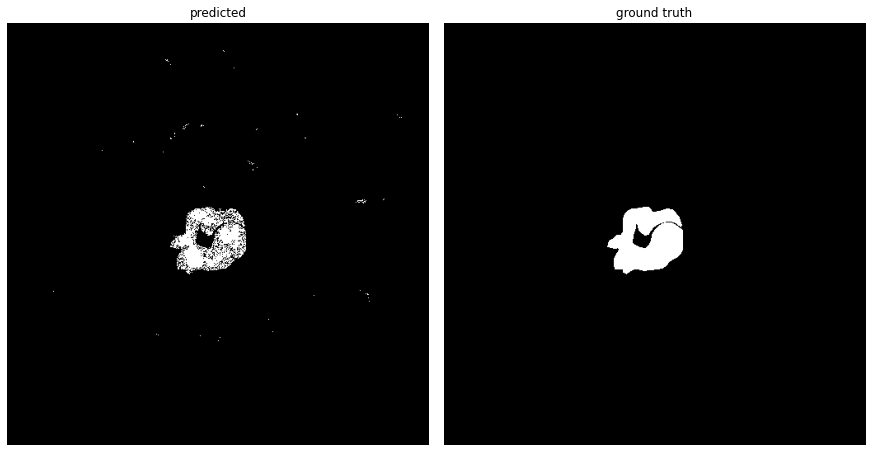

In [84]:
layer = 14

X = features_extraction(slice=denoised_slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_labels(slice=slice, layer=layer)

show_model_result(ground_truth=ground_truth,predicted=predicted)

## Test on different image

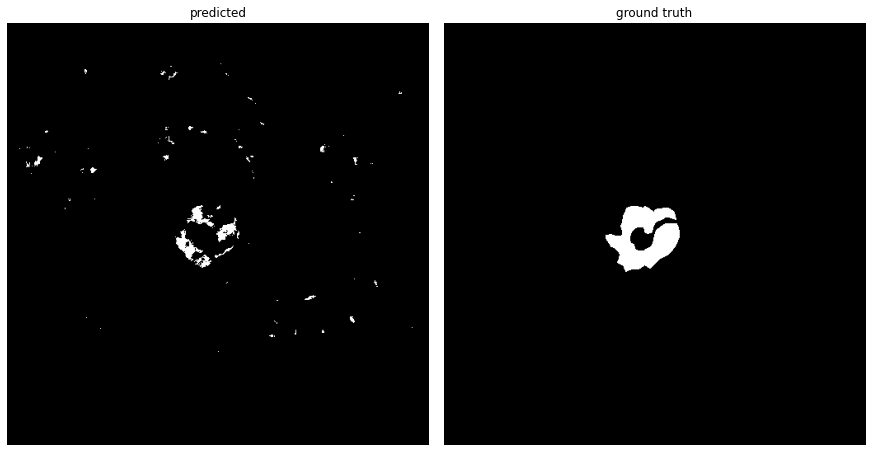

In [86]:
layer = 15

X = features_extraction(slice=denoised_slice, layer=layer, ksize=5, Train_mode=False)
result = load_model.predict(X)

predicted = result.reshape(slice.shape[1:3])
ground_truth = make_labels(slice=denoised_slice, layer=layer)

show_model_result(ground_truth=ground_truth,predicted=predicted)